In [430]:
import pandas as pd
import numpy as np
import math
import mapclassify as mc
import os
import descartes

import geopandas as gpd
import json

from bokeh.layouts import layout

from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import (GeoJSONDataSource, LinearColorMapper, 
                          ColorBar, NumeralTickFormatter, LogColorMapper, GMapPlot, GMapOptions,
                          ColumnDataSource,Button,ContinuousColorMapper)

from bokeh.palettes import brewer, all_palettes

from bokeh.io.doc import curdoc
from bokeh.models import Slider, HoverTool, Select, TextInput, Label, LabelSet
from bokeh.layouts import widgetbox, row, column

from bokeh.application import Application
from bokeh.application.handlers import FunctionHandler

In [431]:
os.environ["BOKEH_ALLOW_WS_ORIGIN"] = 'localhost:8890' # A changer pour mettre le sien
os.environ["BOKEH_RESOURCES"]='inline'

In [432]:
output_notebook()

Loading BokehJS ...

In [433]:
direct = os.getcwd()

#  CLEANING 

## COMMUNES

In [434]:
#Données brutes mdifiée pour mettre github 
#communes = gpd.read_file(direct +'\\shapefile\\communes-20200101.shp')
#communes=communes[pd.to_numeric(communes['insee'], errors='coerce').notnull()]
#communes=communes[communes['insee'].str.startswith(('75','78','91','77','92','94','95','93'))]
#communes=communes[['insee','nom','geometry']]

In [435]:
#communes.to_file(driver='ESRI Shapefile',filename=direct +'\\shapefile\\communes_modif.shp')

In [436]:
communes = gpd.read_file(direct +'/shapefile/communes_modif.shp',encoding='utf-8')
communes=communes.set_geometry('geometry')

PARIS

In [437]:
paris =gpd.read_file(direct +'/shapefile/arrondissements.shp')
paris['c_arinsee']=paris['c_arinsee'].astype(int)
paris=paris[['c_arinsee','l_ar','geometry']]
paris=paris.rename(columns={"c_arinsee": "insee", "l_ar": "nom"})
paris['insee']=paris['insee'].astype(str)
communes = communes.append(paris)

Remarques sur les données  : 
- Utilisables : 1946, 1962,1968, 1975, 1982, 1990 (sdc), 1999 (sdc), 2010
- RER moments forts : 1933 (Paris-Soissons),1949 (Ligne de sceaux), 1977 (jointure chatelet), 1981 (ligne nord/sud complète),
https://www.youtube.com/watch?v=EC91ZWUvfEo 

In [438]:
pop = gpd.read_file(direct + '/shapefile/donnees-communales-sur-la-population-dile-de-france.shp')

In [401]:
pop.columns

Index(['insee', 'pop1946', 'psdc1962', 'psdc1968', 'psdc1975', 'psdc1982',
       'psdc1990', 'popexh1999', 'psdc82df99', 'psdc90df99', 'popmun2006',
       'popmun2007', 'popmun2008', 'popmun2009', 'popmun2010', 'popmun2011',
       'objectid', 'popmun2012', 'popmun2013', 'popmun2014', 'popmun2015',
       'tcam1217', 'popmun2016', 'popmun2017', 'geometry'],
      dtype='object')

In [439]:
#correspondance changements rer et population dates dispo
merge_year = pd.DataFrame({'year_rer':[1946,1962,1968,1975,1982,1990,1999,2006,2012,2017],
                           'year_pop':[1946,1962,1968,1975,1982,1990,1999,2006,2012,2017],
                           'steps':[1,2,3,4,5,6,7,8,9,10]})
# Pa sla première car poucentage croissance

In [440]:
pop.insee=pop.insee.astype(int)
pop.insee=pop.insee.astype(str)
pop=pop[pop['insee'].str.startswith(('75','78','91','77','92','94','95','93'))] #pas mis seine et marne 
pop.columns

Index(['insee', 'pop1946', 'psdc1962', 'psdc1968', 'psdc1975', 'psdc1982',
       'psdc1990', 'popexh1999', 'psdc82df99', 'psdc90df99', 'popmun2006',
       'popmun2007', 'popmun2008', 'popmun2009', 'popmun2010', 'popmun2011',
       'objectid', 'popmun2012', 'popmun2013', 'popmun2014', 'popmun2015',
       'tcam1217', 'popmun2016', 'popmun2017', 'geometry'],
      dtype='object')

In [441]:
# reshape 
#pop=pop[['insee','popmun2006','popmun2007','popmun2008','popmun2009','popmun2010','popmun2011','popmun2012','popmun2013','popmun2014','popmun2015','popmun2016','popmun2017']]

In [442]:
pop=pop[['insee','pop1946','psdc1962','psdc1968','psdc1975','psdc82df99','psdc90df99',
         'popexh1999','popmun2006','popmun2012','popmun2017']]

In [443]:
pop.columns

Index(['insee', 'pop1946', 'psdc1962', 'psdc1968', 'psdc1975', 'psdc82df99',
       'psdc90df99', 'popexh1999', 'popmun2006', 'popmun2012', 'popmun2017'],
      dtype='object')

In [445]:
pop.columns=['insee','1946','1962','1968','1975','1982','1990',
         '1999','2006',
         '2012','2017']

In [446]:
pop.head()

insee     1946     1962     1968     1975     1982     1990     1999  \
0  78562    673.0    680.0    641.0    806.0    969.0   1074.0   1315.0   
1  94068  55520.0  70397.0  77251.0  80920.0  80811.0  77206.0  73071.0   
2  95572   4801.0   6985.0   9957.0  15948.0  17098.0  18673.0  19653.0   
3  77438    546.0    740.0    775.0   1288.0   1412.0   4207.0   6384.0   
4  77404    977.0   1209.0   1178.0   1309.0   1407.0   1555.0   1695.0   

      2006     2012     2017  
0   1409.0   1489.0   1378.0  
1  75214.0  74176.0  74859.0  
2  22681.0  23470.0  23741.0  
3   6446.0   6256.0   6447.0  
4   1705.0   1795.0   1822.0

In [447]:
pop=pd.melt(pop, id_vars=['insee'])
pop=pop.rename(columns={'value':'population'})
pop=pop.rename(columns={'variable':'year'})
pop.year=pop.year.astype(int)

In [448]:
pop=pop[~(pop['population'] <=0)]

In [449]:
#pop['year'] = pd.to_datetime(pop['year'])
pop.sort_values(['insee','year'], inplace = True, ascending=[True, True])

In [450]:
pop['pct_ch'] = (pop.groupby('insee')['population']
                                  .apply(pd.Series.pct_change) + 1)

In [451]:
pop['pct_ch_2'] = (pop['pct_ch']-1)*100

In [452]:
pop.head()

insee  year  population    pct_ch   pct_ch_2
1286  75101  1946     36478.0       NaN        NaN
2573  75101  1962     36543.0  1.001782   0.178190
3860  75101  1968     32332.0  0.884766 -11.523411
5147  75101  1975     22793.0  0.704967 -29.503278
6434  75101  1982     18509.0  0.812048 -18.795244

In [453]:
pop.replace([np.inf, -np.inf], np.nan)
pop.dropna(inplace=True)


In [454]:
#pop=pop[(pop['insee'] !='91692')]

In [455]:
pop.head()

insee  year  population    pct_ch   pct_ch_2
2573  75101  1962     36543.0  1.001782   0.178190
3860  75101  1968     32332.0  0.884766 -11.523411
5147  75101  1975     22793.0  0.704967 -29.503278
6434  75101  1982     18509.0  0.812048 -18.795244
7721  75101  1990     18360.0  0.991950  -0.805014

In [456]:
pop_1962 = pop[pop.year==1962]
pop_1962['pct_ch_2'].quantile(0.90)
pop_1962.pct_ch_2[pop_1962.pct_ch_2 > pop_1962['pct_ch_2'].quantile(0.95)] = pop_1962['pct_ch_2'].quantile(0.95)
pop_1962.pct_ch_2[pop_1962.pct_ch_2 < pop_1962['pct_ch_2'].quantile(0.05)] = pop_1962['pct_ch_2'].quantile(0.05)

C:\Users\morga\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\morga\Anaconda3\lib\site-packages\pandas\core\generic.py:8767: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\morga\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

In [457]:
pop_1968 = pop[pop.year==1968]
pop_1968['pct_ch_2'].quantile(0.90)
pop_1968.pct_ch_2[pop_1968.pct_ch_2 > pop_1968['pct_ch_2'].quantile(0.95)] = pop_1968['pct_ch_2'].quantile(0.95)
pop_1968.pct_ch_2[pop_1968.pct_ch_2 < pop_1968['pct_ch_2'].quantile(0.05)] = pop_1968['pct_ch_2'].quantile(0.05)

C:\Users\morga\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\morga\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [459]:
pop_1975 = pop[pop.year==1975]
pop_1975['pct_ch_2'].quantile(0.90)
pop_1975.pct_ch_2[pop_1975.pct_ch_2 > pop_1975['pct_ch_2'].quantile(0.95)] = pop_1975['pct_ch_2'].quantile(0.95)
pop_1975.pct_ch_2[pop_1975.pct_ch_2 < pop_1975['pct_ch_2'].quantile(0.05)] = pop_1975['pct_ch_2'].quantile(0.05)

C:\Users\morga\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\morga\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [460]:
pop_1982 = pop[pop.year==1982]
pop_1982['pct_ch_2'].quantile(0.90)
pop_1982.pct_ch_2[pop_1982.pct_ch_2 > pop_1982['pct_ch_2'].quantile(0.95)] = pop_1982['pct_ch_2'].quantile(0.95)
pop_1982.pct_ch_2[pop_1982.pct_ch_2 < pop_1982['pct_ch_2'].quantile(0.05)] = pop_1982['pct_ch_2'].quantile(0.05)

C:\Users\morga\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\morga\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [461]:
pop_1990 = pop[pop.year==1990]
pop_1990['pct_ch_2'].quantile(0.90)
pop_1990.pct_ch_2[pop_1990.pct_ch_2 > pop_1990['pct_ch_2'].quantile(0.95)] = pop_1990['pct_ch_2'].quantile(0.95)
pop_1990.pct_ch_2[pop_1990.pct_ch_2 < pop_1990['pct_ch_2'].quantile(0.05)] = pop_1990['pct_ch_2'].quantile(0.05)

C:\Users\morga\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\morga\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [462]:
pop_1999 = pop[pop.year==1999]
pop_1999['pct_ch_2'].quantile(0.90)
pop_1999.pct_ch_2[pop_1999.pct_ch_2 > pop_1999['pct_ch_2'].quantile(0.95)] = pop_1999['pct_ch_2'].quantile(0.95)
pop_1999.pct_ch_2[pop_1999.pct_ch_2 < pop_1999['pct_ch_2'].quantile(0.05)] = pop_1999['pct_ch_2'].quantile(0.05)

C:\Users\morga\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\morga\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [463]:
pop_2006 = pop[pop.year==2006]
pop_2006['pct_ch_2'].quantile(0.90)
pop_2006.pct_ch_2[pop_2006.pct_ch_2 > pop_2006['pct_ch_2'].quantile(0.95)] = pop_2006['pct_ch_2'].quantile(0.95)
pop_2006.pct_ch_2[pop_2006.pct_ch_2 < pop_2006['pct_ch_2'].quantile(0.05)] = pop_2006['pct_ch_2'].quantile(0.05)

C:\Users\morga\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\morga\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [464]:
pop_2007 = pop[pop.year>=2007]
pop_2007['pct_ch_2'].quantile(0.90)
pop_2007.pct_ch_2[pop_2007.pct_ch_2 > pop_2007['pct_ch_2'].quantile(0.95)] = pop_2007['pct_ch_2'].quantile(0.95)
pop_2007.pct_ch_2[pop_2007.pct_ch_2 < pop_2007['pct_ch_2'].quantile(0.05)] = pop_2007['pct_ch_2'].quantile(0.05)

C:\Users\morga\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\morga\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [465]:
frame = [pop_1968,pop_1975,pop_1982,pop_1990,pop_1999,pop_2006,pop_2007]

In [466]:
pop=pop_1962.append(frame)

In [467]:
pop

insee  year  population    pct_ch   pct_ch_2
2573   75101  1962     36543.0  1.001782   0.178190
2572   75102  1962     40864.0  0.986600  -1.339965
1819   75103  1962     62680.0  0.973398  -2.660227
2438   75104  1962     61670.0  1.026431   2.643054
2320   75105  1962     96031.0  0.935902  -6.409832
...      ...   ...         ...       ...        ...
12514  95680  2017     27676.0  1.006546   0.654641
10578  95682  2012       180.0  1.192053  17.408999
11865  95682  2017       185.0  1.027778   2.777778
11478  95690  2012       316.0  0.960486  -3.951368
12765  95690  2017       333.0  1.053797   5.379747

[11582 rows x 5 columns]

In [468]:
pop.groupby('year')['pct_ch_2'].quantile(0.99)

year
1962    112.299287
1968     58.687647
1975     99.062058
1982     73.158223
1990     61.443977
1999     36.161330
2006     25.482372
2012     17.408999
2017     17.408999
Name: pct_ch_2, dtype: float64

In [469]:
pop=pop.merge(merge_year,left_on='year',right_on='year_pop')

In [470]:
pop=pop[['insee','year','population','pct_ch_2','steps']]

In [362]:
#MERGE 

RER

In [496]:
rer  = gpd.read_file(direct + '/shapefile/traces-du-reseau-ferre-idf.shp') 
rer= rer[rer.reseau=='RER B']
rer=rer.set_geometry('geometry')

In [497]:
stations  = gpd.read_file(direct + '/shapefile/emplacement-des-gares-idf-data-generalisee.shp') 


In [498]:
stations=stations[stations['res_com'].str.contains("RER B")]

In [499]:
stations=stations[['nom_long','geometry']]

In [500]:
stations=stations[['nom_long','geometry']]

In [501]:
rer= rer[['objectid','geometry']]

In [502]:
merging=pd.read_csv(direct + '/merging_file.csv')

In [503]:
stations=stations.merge(merging,on='nom_long')

In [504]:
#stations.nom_long

On calule un rond autour de Chatelet

In [505]:
circle = gpd.GeoDataFrame(crs=None, geometry=communes[communes.insee=='75101'].buffer(0.4))

In [506]:
from geopandas.tools import sjoin
pointInPolys = sjoin(communes, circle, how='inner')
pointInPolys

insee                       nom  \
941   75104                4Ã¨me Ardt   
995   75116               16Ã¨me Ardt   
1256  95088        Bonneuil-en-France   
293   78548              Saint-Forget   
266   78406         Milon-la-Chapelle   
...     ...                       ...   
1553  95580                Saint-Witz   
51    78620          Toussus-le-Noble   
2084  77005           Annet-sur-Marne   
2111  77292                     Messy   
1454  95154  Chennevières-lès-Louvres   

                                               geometry  year  population  \
941   POLYGON ((2.36851 48.85573, 2.36900 48.85374, ...  2006     29138.0   
995   POLYGON ((2.27427 48.87837, 2.27749 48.87796, ...  2006    153920.0   
1256  POLYGON ((2.41658 48.96903, 2.41700 48.96915, ...  2006       730.0   
293   POLYGON ((1.97041 48.71726, 1.97086 48.71745, ...  2006       484.0   
266   POLYGON ((2.01909 48.74133, 2.01958 48.74183, ...  2006       321.0   
...                                                 ...   ...         ...   
1553  POLYGON ((2.52366 49.08604, 2.52389 49.08740, ...  2006      2565.0   
51    POLYGON ((2.09839 48.74557, 2.09855 48.74585, ...  2006       831.0   
2084  POLYGON ((2.67110 48.92317, 2.67291 48.92397, ...  2006      3198.0   
2111  POLYGON ((2.67207 48.97648, 2.67301 48.97686, ...  2006      1058.0   
1454  POLYGON ((2.52603 49.03008, 2.52632 49.03165, ...  2006       306.0   

       pct_ch_2  steps  index_right  
941   -4.332452      8          860  
995   -4.332452      8          860  
1256  -4.332452      8          860  
293   -4.332452      8          860  
266   -4.332452      8          860  
...         ...    ...          ...  
1553  25.482372      8          860  
51    25.482372      8          860  
2084  25.482372      8          860  
2111  25.482372      8          860  
1454  25.482372      8          860  

[237 rows x 8 columns]

In [507]:
communes=pointInPolys

In [508]:
communes=communes[['insee','nom','geometry']]

In [509]:
communes

insee                       nom  \
941   75104                4Ã¨me Ardt   
995   75116               16Ã¨me Ardt   
1256  95088        Bonneuil-en-France   
293   78548              Saint-Forget   
266   78406         Milon-la-Chapelle   
...     ...                       ...   
1553  95580                Saint-Witz   
51    78620          Toussus-le-Noble   
2084  77005           Annet-sur-Marne   
2111  77292                     Messy   
1454  95154  Chennevières-lès-Louvres   

                                               geometry  
941   POLYGON ((2.36851 48.85573, 2.36900 48.85374, ...  
995   POLYGON ((2.27427 48.87837, 2.27749 48.87796, ...  
1256  POLYGON ((2.41658 48.96903, 2.41700 48.96915, ...  
293   POLYGON ((1.97041 48.71726, 1.97086 48.71745, ...  
266   POLYGON ((2.01909 48.74133, 2.01958 48.74183, ...  
...                                                 ...  
1553  POLYGON ((2.52366 49.08604, 2.52389 49.08740, ...  
51    POLYGON ((2.09839 48.74557, 2.09855 48.74585, ...  
2084  POLYGON ((2.67110 48.92317, 2.67291 48.92397, ...  
2111  POLYGON ((2.67207 48.97648, 2.67301 48.97686, ...  
1454  POLYGON ((2.52603 49.03008, 2.52632 49.03165, ...  

[237 rows x 3 columns]

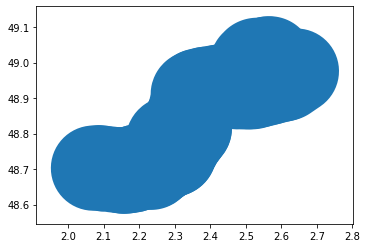

In [510]:
circle_rer.plot()

On ne représentera que les communes qui se trouvent à une distance de 2km du RER 

### PROBLEME

In [511]:
circle_rer = gpd.GeoDataFrame(crs=None, geometry=rer.geometry.buffer(0.12))
communes_rer = sjoin(communes, circle_rer, how='inner',op='within',lsuffix='lft',rsuffix='rgt')

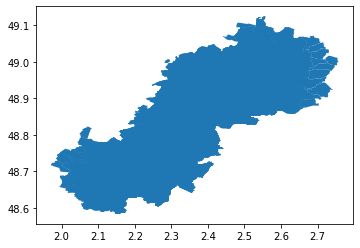

In [512]:
communes_rer.plot()

In [513]:
communes_rer.dropna()

insee                       nom  \
941   75104                4Ã¨me Ardt   
995   75116               16Ã¨me Ardt   
464   91689                   Wissous   
644   91587       Saulx-les-Chartreux   
500   91136                  Champlan   
...     ...                       ...   
1220  93046              Livry-Gargan   
1373  93010                     Bondy   
1526  77291          Le Mesnil-Amelot   
1292  95212        Épiais-lès-Louvres   
1454  95154  Chennevières-lès-Louvres   

                                               geometry  index_rgt  
941   POLYGON ((2.36851 48.85573, 2.36900 48.85374, ...          2  
995   POLYGON ((2.27427 48.87837, 2.27749 48.87796, ...          2  
464   POLYGON ((2.30150 48.71972, 2.30170 48.72036, ...          2  
644   POLYGON ((2.24132 48.68532, 2.24205 48.68572, ...          2  
500   POLYGON ((2.25880 48.70794, 2.25881 48.70836, ...          2  
...                                                 ...        ...  
1220  POLYGON ((2.50570 48.91744, 2.50629 48.91798, ...       1064  
1373  POLYGON ((2.46883 48.89961, 2.46918 48.90030, ...       1064  
1526  POLYGON ((2.56448 49.00731, 2.56660 49.00744, ...       1064  
1292  POLYGON ((2.52520 49.02690, 2.52551 49.02813, ...       1064  
1454  POLYGON ((2.52603 49.03008, 2.52632 49.03165, ...       1064  

[2382 rows x 4 columns]

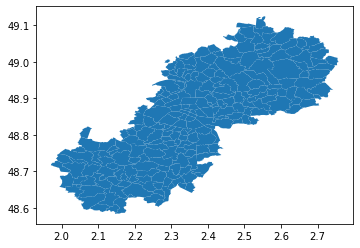

In [514]:
communes_rer.drop_duplicates(subset='insee',inplace = True) 
communes_rer=communes_rer[['insee','nom','geometry']]
communes_rer.plot()

In [515]:
communes=communes_rer

# Un essai avec quatres années : 1975 et 2017 

In [516]:
stations_nom_liste=[]
for i in stations.nom_long:
    stations_nom_liste.append(i)

In [517]:
nom_long_1937=['MASSY-PALAISEAU','LE GUICHET','LOZERE','PALAISEAU-VILLEBON','PALAISEAU','SAINT-REMY-LES-CHEVREUSE',
               'COURCELLE-SUR-YVETTE','LA HACQUINIERE','ORSAY-VILLE','GIF-SUR-YVETTE','BURES-SUR-YVETTE','MASSY-VERRIERES',
              'FONTAINE-MICHALON','ANTONY','LA CROIX-DE-BERNY-FRESNES','PARC-DE-SCEAUX','BOURG-LA-REINE','BAGNEUX',
              'ARCUEIL-CACHAN','LAPLACE','GENTILLY','CITE UNIVERSITAIRE','DENFERT-ROCHEREAU','PORT ROYAL','LES BACONNETS']
nom_long_1977=nom_long_1937+['LUXEMBOURG','SAINT-MICHEL']
nom_long_1981=nom_long_1977+ ['CHATELET-LES HALLES'] #['GARE DU NORD']
nom_long_2017 = stations_nom_liste
list_year = [nom_long_1937,nom_long_1937,nom_long_1977,nom_long_1981,nom_long_2017,
             nom_long_2017,nom_long_2017,nom_long_2017,nom_long_2017,
             nom_long_2017,nom_long_2017,nom_long_2017,nom_long_2017,nom_long_2017,
             nom_long_2017,nom_long_2017,nom_long_2017,nom_long_2017,nom_long_2017]

# Bizarre ici ca me donne aps les bons tracés 1 supplémentaire 

In [518]:
append_stations=pd.DataFrame(columns=['nom_long','geometry','objectid','year'])
append_rer=pd.DataFrame(columns=['objectid','geometry','year'])

In [519]:
for i in range(len(merge_year.year_rer.tolist())):
    data_stations=stations
    data_stations=data_stations.assign(year=merge_year.year_rer.tolist()[i])
    data_stations=data_stations[data_stations.nom_long.isin(list_year[i])]
    append_stations=append_stations.append(data_stations)
    append_stations.year=append_stations.year.astype(int) 
    data_rer=rer.assign(year=merge_year.year_rer.tolist()[i])
    data_rer=data_rer[data_rer.objectid.isin(data_stations.objectid.tolist())]
    append_rer=append_rer.append(data_rer)
    append_rer.year=append_rer.year.astype(int) 

In [520]:
append_rer=append_rer.merge(merge_year,left_on='year',right_on='year_rer',how='left')
append_stations=append_stations.merge(merge_year,left_on='year',right_on='year_rer',how='left')
append_rer=append_rer.set_geometry('geometry')
append_stations=append_stations.set_geometry('geometry')

In [521]:
append_rer[append_rer.objectid==29.0]

objectid                                           geometry  year  \
0        29.0  LINESTRING (2.23731 48.70814, 2.23742 48.70842...  1946   
25       29.0  LINESTRING (2.23731 48.70814, 2.23742 48.70842...  1962   
50       29.0  LINESTRING (2.23731 48.70814, 2.23742 48.70842...  1968   
77       29.0  LINESTRING (2.23731 48.70814, 2.23742 48.70842...  1975   
106      29.0  LINESTRING (2.23731 48.70814, 2.23742 48.70842...  1982   
153      29.0  LINESTRING (2.23731 48.70814, 2.23742 48.70842...  1990   
200      29.0  LINESTRING (2.23731 48.70814, 2.23742 48.70842...  1999   
247      29.0  LINESTRING (2.23731 48.70814, 2.23742 48.70842...  2006   
294      29.0  LINESTRING (2.23731 48.70814, 2.23742 48.70842...  2012   
341      29.0  LINESTRING (2.23731 48.70814, 2.23742 48.70842...  2017   

     year_rer  year_pop  steps  
0        1946      1946      1  
25       1962      1962      2  
50       1968      1968      3  
77       1975      1975      4  
106      1982      1982      5  
153      1990      1990      6  
200      1999      1999      7  
247      2006      2006      8  
294      2012      2012      9  
341      2017      2017     10

In [522]:
communes_pop=pd.merge(communes, pop, on='insee').sort_values('pct_ch_2')

In [523]:
communes_pop

insee                 nom  \
1988  77214              Gressy   
1557  95580          Saint-Witz   
2105  77241              Juilly   
1898  91243  Fontenay-lès-Briis   
2087  77525            Vinantes   
...     ...                 ...   
972   93008             Bobigny   
1772  91534              Saclay   
1152  95277             Gonesse   
234   91027          Athis-Mons   
1979  91434    Morsang-sur-Orge   

                                               geometry  year  population  \
1988  POLYGON ((2.64924 48.96184, 2.65064 48.96304, ...  1962        57.0   
1557  POLYGON ((2.52366 49.08604, 2.52389 49.08740, ...  1962       161.0   
2105  POLYGON ((2.67922 49.01336, 2.68390 49.01933, ...  1962       823.0   
1898  POLYGON ((2.14015 48.61276, 2.14050 48.61279, ...  1962       847.0   
2087  POLYGON ((2.72002 49.00541, 2.72147 49.00628, ...  1962       181.0   
...                                                 ...   ...         ...   
972   POLYGON ((2.41004 48.91662, 2.41124 48.91771, ...  1962     37010.0   
1772  POLYGON ((2.13508 48.73729, 2.13613 48.73888, ...  1962      1666.0   
1152  POLYGON ((2.41646 48.99865, 2.41651 48.99907, ...  1962      8517.0   
234   POLYGON ((2.35381 48.70174, 2.35385 48.70180, ...  1962     24004.0   
1979  POLYGON ((2.33677 48.65044, 2.33824 48.65449, ...  1962      8604.0   

        pct_ch_2  steps  
1988  -24.345606      2  
1557  -24.345606      2  
2105  -24.345606      2  
1898  -24.345606      2  
2087  -18.468468      2  
...          ...    ...  
972   112.299287      2  
1772  112.299287      2  
1152  112.299287      2  
234   112.299287      2  
1979  112.299287      2  

[2132 rows x 7 columns]

###  Save as geojson Paul 

objectid                                           geometry  year  steps
25       29.0  LINESTRING (2.23731 48.70814, 2.23742 48.70842...  1962      2
26       33.0  LINESTRING (2.19273 48.70540, 2.19278 48.70542...  1962      2
27      987.0  LINESTRING (2.30423 48.76169, 2.30449 48.76223...  1962      2
28      985.0  LINESTRING (2.30099 48.75495, 2.30118 48.75542...  1962      2
29      986.0  LINESTRING (2.31021 48.77072, 2.31023 48.77096...  1962      2
..        ...                                                ...   ...    ...
382     235.0  LINESTRING (2.50804 48.93225, 2.50951 48.93230...  2017     10
383     239.0  LINESTRING (2.56123 49.00976, 2.56693 49.01030...  2017     10
384     348.0  LINESTRING (2.31231 48.78031, 2.31252 48.78073...  2017     10
385     988.0  LINESTRING (2.27348 48.73472, 2.27403 48.73490...  2017     10
386    1140.0  LINESTRING (2.34089 48.81523, 2.34079 48.81559...  2017     10

[362 rows x 4 columns]

In [533]:
append_rer=append_rer[append_rer.year>1946]
append_stations = append_stations[append_stations.year>1946]

In [534]:
append_rer=append_rer[['objectid','geometry','year','steps']]

In [535]:
append_stations=append_stations[['nom_long','geometry','objectid','year','steps']]

In [536]:
for i in list(append_rer.steps.unique()):
    rer=append_rer[append_rer['steps']==i]
    rer.to_file("rer2"+str(i)+".geojson", driver='GeoJSON')

In [494]:
for i in list(communes_pop.steps.unique()):
    communes=communes_pop[communes_pop['steps']==i]
    communes.to_file("communes_pop2"+str(i)+".geojson", driver='GeoJSON')

In [495]:
for i in list(append_stations.steps.unique()):
    stat=append_stations[append_stations['steps']==i]
    stat.to_file("stations2"+str(i)+".geojson", driver='GeoJSON')

In [237]:
communes_sans_noms=communes[['insee','geometry']]

In [239]:
merged = communes_sans_noms.merge(pop, on = 'insee', how = 'inner')

In [115]:
merged.to_file("pop_comgeo.geojson", driver='GeoJSON')

In [ ]:
append_rer.to_file("rer.geojson", driver='GeoJSON')

In [ ]:
append_stations.to_file("stations.geojson",driver='GeoJSON')

In [178]:
variables=pd.read_csv(r'C:\Users\morga\Documents\GitHub\MLPython\dataviz\variables_candidat_couleur.csv')

In [ ]:
merged=merged[['insee','nom','year','population','pct_ch','steps']]

In [ ]:
merged.to_csv('population.csv')

In [ ]:
variables_noms=merged.drop_duplicates(subset=['insee','nom'])
variables_noms['nom']=variables_noms.nom.str.replace("Ã¨me Ardt", "e Ardt", case = False)

In [ ]:
variables_noms.insee=variables_noms.insee.astype(int)

In [ ]:
variables.merge(variables_noms,on='insee',how='left').to_csv('variables_noms.csv')

In [37]:
import geopandas as gpd

pop=gpd.read_file('pop_sansnoms.geojson')

In [38]:
pop.set_geometry('geometry')

insee  year  population    pct_ch  steps  \
0     95492  1962       132.0  1.168142      2   
1     95492  1968        94.0  0.712121      3   
2     95492  1975        89.0  0.946809      4   
3     95492  1982        67.0  0.752809      5   
4     95492  1990        79.0  1.179104      6   
...     ...   ...         ...       ...    ...   
4260  95675  2013       787.0  0.965644     15   
4261  95675  2014       758.0  0.963151     16   
4262  95675  2015       755.0  0.996042     17   
4263  95675  2016       748.0  0.990728     18   
4264  95675  2017      1001.0  1.338235     19   

                                               geometry  
0     POLYGON ((2.39899 49.03985, 2.39933 49.04032, ...  
1     POLYGON ((2.39899 49.03985, 2.39933 49.04032, ...  
2     POLYGON ((2.39899 49.03985, 2.39933 49.04032, ...  
3     POLYGON ((2.39899 49.03985, 2.39933 49.04032, ...  
4     POLYGON ((2.39899 49.03985, 2.39933 49.04032, ...  
...                                                 ...  
4260  POLYGON ((2.51542 49.05298, 2.51694 49.05494, ...  
4261  POLYGON ((2.51542 49.05298, 2.51694 49.05494, ...  
4262  POLYGON ((2.51542 49.05298, 2.51694 49.05494, ...  
4263  POLYGON ((2.51542 49.05298, 2.51694 49.05494, ...  
4264  POLYGON ((2.51542 49.05298, 2.51694 49.05494, ...  

[4265 rows x 6 columns]

In [45]:
pop=pop[pop.steps>15]

In [47]:
pop=pop.drop_duplicates('insee')

In [48]:
pop.to_file('pop_sansnoms2.geojson', driver='GeoJSON')

# Autre essai OK ! 

In [46]:
from bokeh.plotting import figure, output_file, save
def json_data(selectedYear):
    yr = selectedYear
    df_pop = pop[pop['steps'] == yr]
    merged = communes.merge(df_pop, on = 'insee', how = 'left')
    #merged=merged.assign(densite=merged.population/merged.geometry.area)
    merged_json = json.loads(merged.to_json())
    json_data = json.dumps(merged_json)
    return json_data

def json_data_rer(selectedYear):
    yr = selectedYear
    df_rer = append_rer[append_rer['steps'] == yr]
    merged_json = json.loads(df_rer.to_json())
    json_data = json.dumps(merged_json)
    return json_data

def json_data_stations(selectedYear):
    yr = selectedYear
    df_stations = append_stations[append_stations['steps'] == yr]
    merged_json = json.loads(df_stations.to_json())
    json_data = json.dumps(merged_json)
    return json_data

#Input GeoJSON source that contains features for plotting.
geosource = GeoJSONDataSource(geojson = json_data(1))
rersource=GeoJSONDataSource(geojson = json_data_rer(1))
stationssource=GeoJSONDataSource(geojson = json_data_stations(1))
#Define a sequential multi-hue color palette.
palette = brewer['Reds'][8]
#Reverse color order so that dark blue is highest obesity.
palette = palette[::-1]
#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors. Input nan_color.
#high_value = pd.merge(communes, pop, on='insee').assign(densite=pd.merge(communes, pop, on='insee').population/pd.merge(communes, pop, on='insee').geometry.area).densite.max()
high_value = pd.merge(communes, pop, on='insee')[pd.merge(communes, pop, on='insee').steps==1].pct_ch.max()
color_mapper = LogColorMapper(palette = palette, low = 0.5, high = high_value, nan_color = '#d9d9d9')

#Create figure object.
p = figure(title = 'Population le long du RER B, 2017', plot_height = 600 , plot_width = 950)
p.title.text_color = "gray"
p.title.text_font = "arial"
p.title.text_font_style = "italic"
p.title.text_font_size = "20pt"
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
#Add patch renderer to figure. 
p.patches('xs','ys', source = geosource, fill_color = {'field' : 'pct_ch', 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)

p.multi_line('xs', 'ys', source=rersource, color='#4B92DB', line_width=5)

circle=p.circle('x', 'y', size=4, source=stationssource, color="white")

label_text=Label(x=2,y=49,text='2017',text_font_size='60pt', text_color='#eeeeee')
#labels = LabelSet(x='weight', y='height', text='names', level='glyph',
            #  x_offset=5, y_offset=5, source=source, render_mode='canvas')
p.add_layout(label_text)

phover = HoverTool(renderers=[circle])
phover.tooltips=[('stations','@nom_long')]

p.add_tools(phover)

color_bar = ColorBar(color_mapper=color_mapper, label_standoff=18,border_line_color=None, location = (0, 0))
p.add_layout(color_bar, 'right')


# Define the callback function: update_plot
'''
def animate_update():
    year = slider.value + 1
    if year > steps[-1]:
        year = steps[0]
    slider.value = year
    

callback_id = None

def animate():
    global callback_id
    if button.label == '► Play':
        button.label = '❚❚ Pause'
        callback_id = doc.add_periodic_callback(animate_update, 200)
    else:
        button.label = '► Play'
        doc.remove_periodic_callback(callback_id)

button = Button(label='► Play', width=60)
button.on_click(animate)

'''

    
def update_plot(attr, old, new):
    yr = slider.value
    new_data = json_data(yr)
    geosource.geojson = new_data
    new_data_rer=json_data_rer(yr)
    rersource.geojson = new_data_rer
    new_data_stations=json_data_stations(yr)
    stationssource.geojson = new_data_stations
    yr_real = merge_year[merge_year['steps']==yr].year_rer
    p.title.text = 'Population le long du RER B, %d' %yr_real
    label_text.text=  str(int(yr_real))
    high_value = pd.merge(communes, pop, on='insee')[pd.merge(communes, pop, on='insee').steps==yr].pct_ch.max()
    low_value = pd.merge(communes, pop, on='insee')[pd.merge(communes, pop, on='insee').steps==yr].pct_ch.min()
    color_mapper = LogColorMapper(palette = palette, low = low_value, high = high_value, nan_color = '#d9d9d9')




slider = Slider(title = 'Year',start = 1, end = 9, step = 1, value = 1)
slider.on_change('value', update_plot)
# Make a column layout of widgetbox(slider) and plot, and add it to the current document

layout = column(p,widgetbox(slider)) #button

output_file('flowers.html')
save(p)

'C:\\Users\\morga\\Documents\\GitHub\\MLPython\\dataviz\\Graphique_bokeh\\flowers.html'

In [58]:
from bokeh.io import curdoc

from bokeh.plotting import figure, output_file, save
def json_data(selectedYear):
    yr = selectedYear
    df_pop = pop[pop['steps'] == yr]
    merged = communes.merge(df_pop, on = 'insee', how = 'left')
    #merged=merged.assign(densite=merged.population/merged.geometry.area)
    merged_json = json.loads(merged.to_json())
    json_data = json.dumps(merged_json)
    return json_data

def json_data_rer(selectedYear):
    yr = selectedYear
    df_rer = append_rer[append_rer['steps'] == yr]
    merged_json = json.loads(df_rer.to_json())
    json_data = json.dumps(merged_json)
    return json_data

def json_data_stations(selectedYear):
    yr = selectedYear
    df_stations = append_stations[append_stations['steps'] == yr]
    merged_json = json.loads(df_stations.to_json())
    json_data = json.dumps(merged_json)
    return json_data

#Input GeoJSON source that contains features for plotting.
geosource = GeoJSONDataSource(geojson = json_data(1))
rersource=GeoJSONDataSource(geojson = json_data_rer(1))
stationssource=GeoJSONDataSource(geojson = json_data_stations(1))
#Define a sequential multi-hue color palette.
palette = brewer['Reds'][8]
#Reverse color order so that dark blue is highest obesity.
palette = palette[::-1]
#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors. Input nan_color.
#high_value = pd.merge(communes, pop, on='insee').assign(densite=pd.merge(communes, pop, on='insee').population/pd.merge(communes, pop, on='insee').geometry.area).densite.max()
high_value = pd.merge(communes, pop, on='insee')[pd.merge(communes, pop, on='insee').steps==1].pct_ch.max()
color_mapper = LogColorMapper(palette = palette, low = 0.5, high = high_value, nan_color = '#d9d9d9')

#Create figure object.
p = figure(title = 'Population le long du RER B, 2017', plot_height = 600 , plot_width = 950)
p.title.text_color = "gray"
p.title.text_font = "arial"
p.title.text_font_style = "italic"
p.title.text_font_size = "20pt"
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
#Add patch renderer to figure. 
p.patches('xs','ys', source = geosource, fill_color = {'field' : 'pct_ch', 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)

p.multi_line('xs', 'ys', source=rersource, color='#4B92DB', line_width=5)

circle=p.circle('x', 'y', size=4, source=stationssource, color="white")

label_text=Label(x=2,y=49,text='2017',text_font_size='60pt', text_color='#eeeeee')
#labels = LabelSet(x='weight', y='height', text='names', level='glyph',
            #  x_offset=5, y_offset=5, source=source, render_mode='canvas')
p.add_layout(label_text)

phover = HoverTool(renderers=[circle])
phover.tooltips=[('stations','@nom_long')]

p.add_tools(phover)

color_bar = ColorBar(color_mapper=color_mapper, label_standoff=18,border_line_color=None, location = (0, 0))
p.add_layout(color_bar, 'right')


# Define the callback function: update_plot
'''
def animate_update():
    year = slider.value + 1
    if year > steps[-1]:
        year = steps[0]
    slider.value = year
    

callback_id = None

def animate():
    global callback_id
    if button.label == '► Play':
        button.label = '❚❚ Pause'
        callback_id = doc.add_periodic_callback(animate_update, 200)
    else:
        button.label = '► Play'
        doc.remove_periodic_callback(callback_id)

button = Button(label='► Play', width=60)
button.on_click(animate)

'''
    
def update_plot(attr, old, new):
    yr = slider.value
    new_data = json_data(yr)
    geosource.geojson = new_data
    new_data_rer=json_data_rer(yr)
    rersource.geojson = new_data_rer
    new_data_stations=json_data_stations(yr)
    stationssource.geojson = new_data_stations
    yr_real = merge_year[merge_year['steps']==yr].year_rer
    p.title.text = 'Population le long du RER B, %d' %yr_real
    label_text.text=  str(int(yr_real))
    high_value = pd.merge(communes, pop, on='insee')[pd.merge(communes, pop, on='insee').steps==yr].pct_ch.max()
    low_value = pd.merge(communes, pop, on='insee')[pd.merge(communes, pop, on='insee').steps==yr].pct_ch.min()
    color_mapper = LogColorMapper(palette = palette, low = low_value, high = high_value, nan_color = '#d9d9d9')




slider = Slider(title = 'Year',start = 1, end = 9, step = 1, value = 1)
slider.on_change('value', update_plot)
# Make a column layout of widgetbox(slider) and plot, and add it to the current document

layout = column(p,widgetbox(slider)) #button

curdoc().add_root(layout)
curdoc().title = "RER"
save(curdoc())

In [65]:
json_data_rer(1)

'{"type": "FeatureCollection", "features": [{"id": "0", "type": "Feature", "properties": {"objectid": 29.0, "steps": 1, "year": 1962, "year_pop": 1962, "year_rer": 1962}, "geometry": {"type": "LineString", "coordinates": [[2.237314364639455, 48.708140583645324], [2.237418729027951, 48.70842188398586], [2.237510688918529, 48.70868128351074], [2.237599954351252, 48.708889093136015], [2.23775841360432, 48.70915002094207], [2.237868749915823, 48.70932827578573], [2.238009085210476, 48.7095063506097], [2.238108011855648, 48.70964042815748], [2.23820428101999, 48.7097448274295], [2.238361009722594, 48.70990909240042], [2.238546022965989, 48.710088645293865], [2.238936685087797, 48.710434303225945], [2.239146558234102, 48.710611888190925], [2.239478386022654, 48.71090668576398], [2.239735628503226, 48.71115710358904], [2.239907827811196, 48.71134969494287], [2.240199359255079, 48.7116709830965], [2.24041627368749, 48.71193105735823], [2.240615581872578, 48.712162339291574], [2.240880611870904

In [ ]:
from bokeh.io import curdoc

output_file("callback.html")

from bokeh.plotting import figure, output_file, save
def json_data(selectedYear):
    yr = selectedYear
    df_pop = pop[pop['steps'] == yr]
    merged = communes.merge(df_pop, on = 'insee', how = 'left')
    #merged=merged.assign(densite=merged.population/merged.geometry.area)
    merged_json = json.loads(merged.to_json())
    json_data = json.dumps(merged_json)
    return json_data

def json_data_rer(selectedYear):
    yr = selectedYear
    df_rer = append_rer[append_rer['steps'] == yr]
    merged_json = json.loads(df_rer.to_json())
    json_data = json.dumps(merged_json)
    return json_data

def json_data_stations(selectedYear):
    yr = selectedYear
    df_stations = append_stations[append_stations['steps'] == yr]
    merged_json = json.loads(df_stations.to_json())
    json_data = json.dumps(merged_json)
    return json_data

#Input GeoJSON source that contains features for plotting.
geosource = GeoJSONDataSource(geojson = json_data(1))
rersource=GeoJSONDataSource(geojson = json_data_rer(1))
stationssource=GeoJSONDataSource(geojson = json_data_stations(1))
#Define a sequential multi-hue color palette.
palette = brewer['Reds'][8]
#Reverse color order so that dark blue is highest obesity.
palette = palette[::-1]
#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors. Input nan_color.
#high_value = pd.merge(communes, pop, on='insee').assign(densite=pd.merge(communes, pop, on='insee').population/pd.merge(communes, pop, on='insee').geometry.area).densite.max()
high_value = pd.merge(communes, pop, on='insee')[pd.merge(communes, pop, on='insee').steps==1].pct_ch.max()
color_mapper = LogColorMapper(palette = palette, low = 0.5, high = high_value, nan_color = '#d9d9d9')

#Create figure object.
p = figure(title = 'Population le long du RER B, 2017', plot_height = 600 , plot_width = 950)
p.title.text_color = "gray"
p.title.text_font = "arial"
p.title.text_font_style = "italic"
p.title.text_font_size = "20pt"
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
#Add patch renderer to figure. 
p.patches('xs','ys', source = geosource, fill_color = {'field' : 'pct_ch', 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)

p.multi_line('xs', 'ys', source=rersource, color='#4B92DB', line_width=5)

circle=p.circle('x', 'y', size=4, source=stationssource, color="white")

label_text=Label(x=2,y=49,text='2017',text_font_size='60pt', text_color='#eeeeee')
#labels = LabelSet(x='weight', y='height', text='names', level='glyph',
            #  x_offset=5, y_offset=5, source=source, render_mode='canvas')
p.add_layout(label_text)

phover = HoverTool(renderers=[circle])
phover.tooltips=[('stations','@nom_long')]

p.add_tools(phover)

color_bar = ColorBar(color_mapper=color_mapper, label_standoff=18,border_line_color=None, location = (0, 0))
p.add_layout(color_bar, 'right')


# Define the callback function: update_plot
'''
def animate_update():
    year = slider.value + 1
    if year > steps[-1]:
        year = steps[0]
    slider.value = year
    

callback_id = None

def animate():
    global callback_id
    if button.label == '► Play':
        button.label = '❚❚ Pause'
        callback_id = doc.add_periodic_callback(animate_update, 200)
    else:
        button.label = '► Play'
        doc.remove_periodic_callback(callback_id)

button = Button(label='► Play', width=60)
button.on_click(animate)

'''
    
def update_plot(attr, old, new):
    yr = slider.value
    new_data = json_data(yr)
    geosource.geojson = new_data
    new_data_rer=json_data_rer(yr)
    rersource.geojson = new_data_rer
    new_data_stations=json_data_stations(yr)
    stationssource.geojson = new_data_stations
    yr_real = merge_year[merge_year['steps']==yr].year_rer
    p.title.text = 'Population le long du RER B, %d' %yr_real
    label_text.text=  str(int(yr_real))
    high_value = pd.merge(communes, pop, on='insee')[pd.merge(communes, pop, on='insee').steps==yr].pct_ch.max()
    low_value = pd.merge(communes, pop, on='insee')[pd.merge(communes, pop, on='insee').steps==yr].pct_ch.min()
    color_mapper = LogColorMapper(palette = palette, low = low_value, high = high_value, nan_color = '#d9d9d9')



callback = CustomJS(args=dict(geosource=geosource), code="""
        var data = geosource.data;
        var f = cb_obj.value
        var x = data['x']
        var y = data['y']
        for (var i = 0; i < x.length; i++) {
            y[i] = Math.pow(x[i], f)
        }
        source.change.emit();
    """)

slider = Slider(start=0.1, end=4, value=1, step=.1, title="power")
slider.js_on_change('value', callback)


slider = Slider(title = 'Year',start = 1, end = 9, step = 1, value = 1)
slider.js_on_change('value', callback)
# Make a column layout of widgetbox(slider) and plot, and add it to the current document



layout = column(slider, plot)

show(layout)

In [60]:
save(curdoc())

You are generating standalone HTML/JS output, but trying to use real Python
callbacks (i.e. with on_change or on_event). This combination cannot work.

Only JavaScript callbacks may be used with standalone output. For more
information on JavaScript callbacks with Bokeh, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/interaction/callbacks.html

Alternatively, to use real Python callbacks, a Bokeh server application may
be used. For more information on building and running Bokeh applications, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/server.html



'C:\\Users\\morga\\Documents\\GitHub\\MLPython\\dataviz\\Graphique_bokeh\\flowers.html'

In [ ]:

def modify_doc(doc):
    doc.add_root(row(layout, width=800))

    
from bokeh.embed import components

script, div = components([p, ])
print script, div[0], div[1]


handler = FunctionHandler(modify_doc)
output_file('plot.html')
app = Application(handler)
save(app)

In [57]:
from bokeh.plotting import figure
from bokeh.resources import CDN
from bokeh.embed import file_html
from bokeh

html = file_html(p, CDN, "my plot")

'\n\n\n\n<!DOCTYPE html>\n<html lang="en">\n  \n  <head>\n    \n      <meta charset="utf-8">\n      <title>my plot</title>\n      \n      \n        \n          \n        \n        \n          \n        <script type="text/javascript">\n            /* BEGIN bokeh.min.js */\n                /*!\n                 * Copyright (c) 2012 - 2020, Anaconda, Inc., and Bokeh Contributors\n                 * All rights reserved.\n                 * \n                 * Redistribution and use in source and binary forms, with or without modification,\n                 * are permitted provided that the following conditions are met:\n                 * \n                 * Redistributions of source code must retain the above copyright notice,\n                 * this list of conditions and the following disclaimer.\n                 * \n                 * Redistributions in binary form must reproduce the above copyright notice,\n                 * this list of conditions and the following disclaimer in
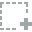
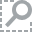
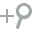
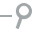
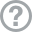
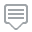
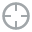
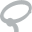
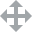
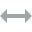
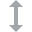
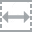
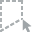
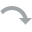
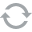
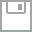
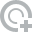
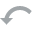
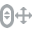
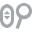
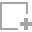
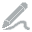
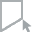
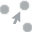
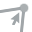

In [58]:
html

Comment ajouter Github ? 

In [59]:
from bokeh.plotting import figure, show, output_file

In [ ]:
output_file('plot.html')

In [62]:
from bokeh.embed import components, json_item
from bokeh.embed import file_html
from bokeh.resources import CDN
script, div = components(p)
print(div)


<div class="bk-root" id="ae7a46ca-5545-4b05-9d51-803e8f785f1b" data-root-id="1349"></div>


In [63]:
j=json.dumps(json_item(layout, "myplot"))

You are generating standalone HTML/JS output, but trying to use real Python
callbacks (i.e. with on_change or on_event). This combination cannot work.

Only JavaScript callbacks may be used with standalone output. For more
information on JavaScript callbacks with Bokeh, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/interaction/callbacks.html

Alternatively, to use real Python callbacks, a Bokeh server application may
be used. For more information on building and running Bokeh applications, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/server.html



In [53]:
html = file_html(p, CDN, "my plot")

In [54]:
print(html)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

ERROR:tornado.application:Uncaught exception GET /autoload.js?bokeh-autoload-element=1059&bokeh-absolute-url=http://localhost:58198&resources=none (::1)
HTTPServerRequest(protocol='http', host='localhost:58198', method='GET', uri='/autoload.js?bokeh-autoload-element=1059&bokeh-absolute-url=http://localhost:58198&resources=none', version='HTTP/1.1', remote_ip='::1')
Traceback (most recent call last):
  File "C:\Users\morga\AppData\Roaming\Python\Python37\site-packages\tornado\web.py", line 1699, in _execute
    result = await result
  File "C:\Users\morga\Anaconda3\lib\site-packages\bokeh\server\views\autoload_js_handler.py", line 54, in get
    session = await sel

https://p-mckenzie.github.io/2017/12/01/embedding-bokeh-with-github-pages/